In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pickle
import copy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import xgboost as xgb
import pprint

In [4]:
filename = "./xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
geolocator = Nominatim(user_agent="aco-application")

[20:10:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 11,
                  'pickup_minute': 0,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]




In [6]:
def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))



In [7]:

def total_cost_from_path(path):
    """
    Calculate the time (in minutes) to travel a path
    using the trained XGB model
    """
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    return total_cost


In [8]:
n = 10  # population size
mutation = 0.5  # mutation factor
crossover = 0.7  # crossover rate
loc_count = 100
generations = 100

In [12]:
locations = []
points = []

df = pd.read_csv("./test.csv")[:100]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))

In [15]:
from tqdm import tqdm
# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in tqdm(range(rank)):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


In [16]:
# Initialize the population based on population size n
population = []
for i in range(n):
    new_path = [j for j in range(loc_count)]
    random.shuffle(new_path)
    population.append(new_path)

In [17]:
# Lists used for plotting at the end
x_values = [i for i in range(generations)]
y_values = []
avg_costs = []

best_cost = 0
best_path = []

In [26]:

# Begin main loop to find candidate answer
for g in range(generations):
    # Store the generation's best costs
    g_star = []
    # Iterate through each path in population
    for i in range(n):
        # Mutation
        # Select a random path, not including current
        indicies = [j for j in range(n)]
        indicies.remove(i)
        mutant_index = int(random.sample(indicies, 1)[0])
        mutant_candidate = population[mutant_index]

        # Swap indicies based on mutation rate
        mutated_path = []
        for d in range(loc_count):
            if random.random() <= mutation and d > 0:
                mutated_path.append(mutated_path[d-1])
                mutated_path[d-1] = mutant_candidate[d]
            else:
                mutated_path.append(mutant_candidate[d])

        # Crossover
        # Create candidate path by crossing over with mutant
        curr_element = population[i]
        candidate = []
        for d in range(loc_count):
            # Roll for chance to crossover value
            if random.random() <= crossover:
                candidate.append(mutated_path[d])
            else:
                candidate.append(curr_element[d])

        # Remove duplicate indicies
        candidate = list(dict.fromkeys(candidate))
        # Find missing indicies
        missing_indicies = []
        for d in range(loc_count):
            if d not in candidate:
                missing_indicies.append(d)

        # Merge candidate with shuffled missing indicies
        random.shuffle(missing_indicies)
        candidate += missing_indicies

        # Selection
        # Select parent based on smaller path cost
        candidate_cost = total_cost_from_path(candidate)
        curr_cost = total_cost_from_path(curr_element)

        if candidate_cost < curr_cost:
            population[i] = copy.copy(candidate)
            g_star.append(candidate_cost)
        else:
            g_star.append(curr_cost)

    best_cost = min(g_star)
    y_values.append(best_cost)
    avg_costs.append(np.mean(g_star))
    best_path = population[g_star.index(best_cost)]
    print("Generation #" + str(g+1) + " best cost:",
          best_cost, "path:", best_path)

Generation #1 best cost: 1742.8228797912598 path: [86, 32, 39, 20, 54, 50, 46, 66, 22, 90, 13, 41, 87, 37, 82, 70, 96, 69, 15, 40, 29, 49, 44, 85, 63, 30, 19, 93, 45, 92, 3, 16, 91, 28, 10, 84, 58, 21, 6, 94, 26, 72, 95, 52, 51, 53, 36, 77, 48, 57, 65, 56, 18, 42, 27, 43, 11, 2, 68, 83, 59, 31, 76, 98, 38, 79, 8, 7, 81, 47, 64, 0, 4, 17, 5, 25, 55, 12, 1, 14, 80, 67, 75, 71, 99, 73, 89, 78, 33, 88, 34, 97, 24, 60, 35, 74, 9, 61, 23, 62]
Generation #2 best cost: 1742.8228797912598 path: [86, 32, 39, 20, 54, 50, 46, 66, 22, 90, 13, 41, 87, 37, 82, 70, 96, 69, 15, 40, 29, 49, 44, 85, 63, 30, 19, 93, 45, 92, 3, 16, 91, 28, 10, 84, 58, 21, 6, 94, 26, 72, 95, 52, 51, 53, 36, 77, 48, 57, 65, 56, 18, 42, 27, 43, 11, 2, 68, 83, 59, 31, 76, 98, 38, 79, 8, 7, 81, 47, 64, 0, 4, 17, 5, 25, 55, 12, 1, 14, 80, 67, 75, 71, 99, 73, 89, 78, 33, 88, 34, 97, 24, 60, 35, 74, 9, 61, 23, 62]
Generation #3 best cost: 1742.8228797912598 path: [86, 32, 39, 20, 54, 50, 46, 66, 22, 90, 13, 41, 87, 37, 82, 70, 96,

In [27]:
print("Min cost mean:", np.mean(y_values))
print("Min cost standard deviation:", np.std(y_values))

print('Final cost: {} minutes, path: {}'.format(best_cost, best_path))


Min cost mean: 1720.138618979288
Min cost standard deviation: 66.89078328789473
Final cost: 1657.688155055046 minutes, path: [86, 7, 97, 32, 20, 78, 75, 24, 13, 22, 37, 12, 25, 65, 55, 23, 40, 92, 8, 54, 28, 93, 91, 80, 10, 1, 57, 56, 48, 3, 95, 84, 42, 21, 27, 99, 5, 62, 36, 98, 35, 19, 67, 43, 6, 89, 68, 15, 26, 82, 77, 53, 4, 59, 18, 49, 81, 33, 47, 2, 90, 96, 45, 63, 73, 41, 69, 14, 31, 70, 30, 52, 88, 85, 46, 0, 16, 9, 79, 64, 17, 71, 39, 11, 74, 34, 94, 60, 50, 66, 61, 58, 76, 51, 83, 29, 38, 72, 87, 44]


In [28]:
# Print out final addresses in solution
print("Final path addresses:")
try:
    addresses = []
    for p in best_path:
        addresses.append(geolocator.reverse(
            f"{points[p][1]}, {points[p][0]}").address)
    pprint.pprint(addresses)
except GeocoderTimedOut as e:
    print(f"Error: geocode failed with message {e}")

Final path addresses:
['101, East 69th Street, Manhattan Community Board 8, Manhattan, New York '
 'County, New York, 10021, United States',
 'Bank of America, Peter Minuit Plaza, Financial District, Manhattan Community '
 'Board 1, Manhattan, New York, 10004, United States',
 'Caffè Palermo, 148, Mulberry Street, Manhattan Community Board 2, Manhattan, '
 'New York, 10013, United States',
 '681, Greenwich Street, West Village, Manhattan Community Board 2, Manhattan, '
 'New York, 10014, United States',
 'Bleecker Street, Mulberry Street, Manhattan Community Board 2, Manhattan, '
 'New York, 10012-3332, United States',
 '121, 1st Avenue, East Village, Manhattan Community Board 3, Manhattan, New '
 'York, 10003, United States',
 'Kent Avenue, Brooklyn, New York, 11211, United States',
 '109, East 27th Street, Rose Hill, Manhattan Community Board 5, Manhattan, '
 'New York, 10016, United States',
 'Washington Irving High School, East 16th Street, Union Square, Manhattan '
 'Community Boa

In [32]:

# Plot out the results
x = []
y = []
for point in points:
    x.append(point[0])
    y.append(point[1])
plt.plot(x, y, 'co')

for _ in range(1, len(best_path)):
    i = best_path[_ - 1]
    j = best_path[_]
    plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
              color='r', length_includes_head=True)


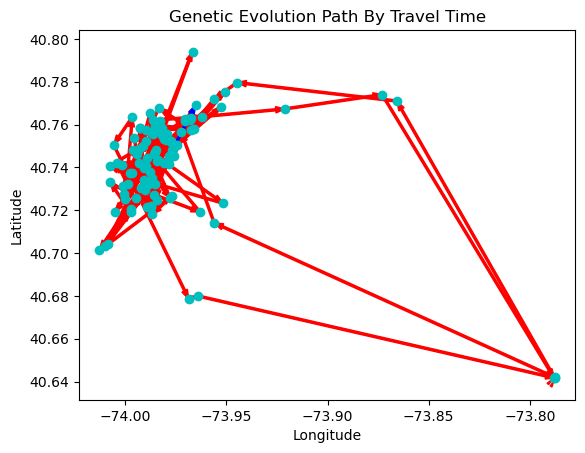

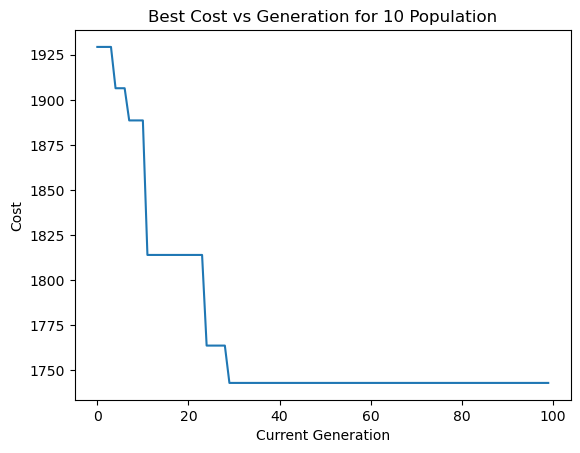

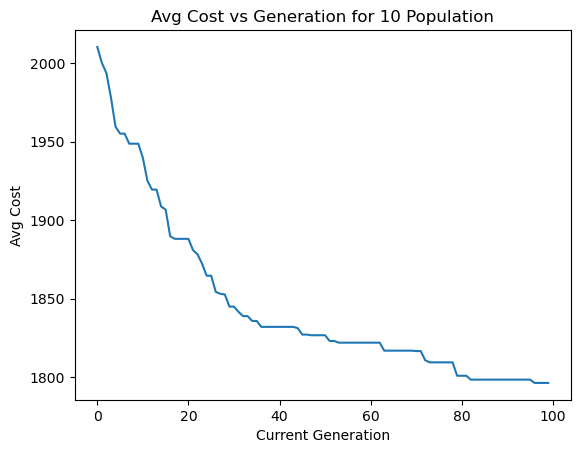

In [33]:
# Close the loop and highlight the last and first point path
i = best_path[-1]  # Last point index
j = best_path[0]  # First point index
plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
          color='b', length_includes_head=True)

zoom_factor = 0.01
plt.xlim(min(x) - zoom_factor, max(x) + zoom_factor)
plt.ylim(min(y) - zoom_factor, max(y) + zoom_factor)
plt.title("Genetic Evolution Path By Travel Time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.title("Best Cost vs Generation for " + str(n) + " Population")
plt.ylabel("Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, y_values[:100])
plt.show()

plt.title("Avg Cost vs Generation for " + str(n) + " Population")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs[:100])
plt.show()
